# **SMS Spam Classification**
---
Collection of SMS messages tagged as spam or legitimate

In [1]:
!pip install --upgrade nltk
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.2 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/3f/61/047b353f0ad550226ef962da182b4a09b689eb6df6bd84a03e44f9ee95bb/scikit_learn-1.4.0-1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 53.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [3]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

In [4]:
nltk.download('punkt')  # Downloads the 'punkt' resource which is often needed
nltk.download('wordnet')  # Downloads the 'wordnet' resource
nltk.download('averaged_perceptron_tagger')  # Downloads the 'averaged_perceptron_tagger' resource
# nltk.download('all')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
#Loading data
data = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='latin1')

# **Exploratory Data Analysis**
---

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [8]:
# Dropping the redundent looking collumns (for this project)
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)
# Renaming the columns because I feel fancy today 
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Text(0, 0.5, 'Number of Data points')

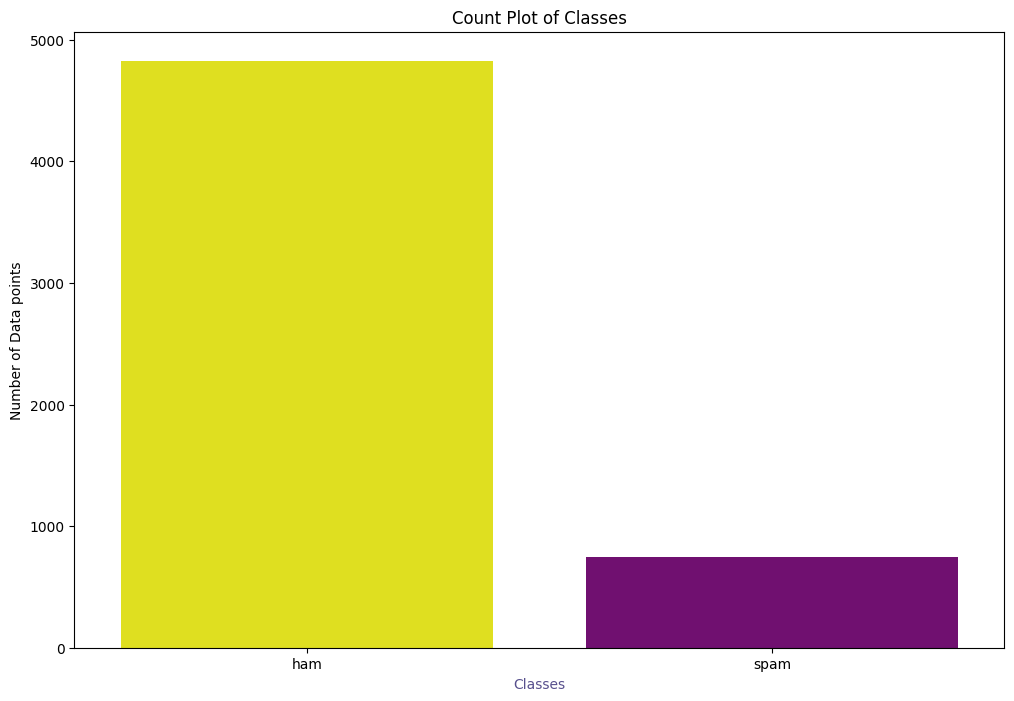

In [9]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data["Target"], palette=['yellow','purple'])
fg.set_title("Count Plot of Classes")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points")

# **Feature Engineering**
---

In [10]:
#Adding a column of numbers of charachters,words and sentences in each msg
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

#PS. At this step, I tokenised the words and sentences and used the length of the same. 
#More on Tokenizing later in the notebook.

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


<Figure size 1200x800 with 0 Axes>

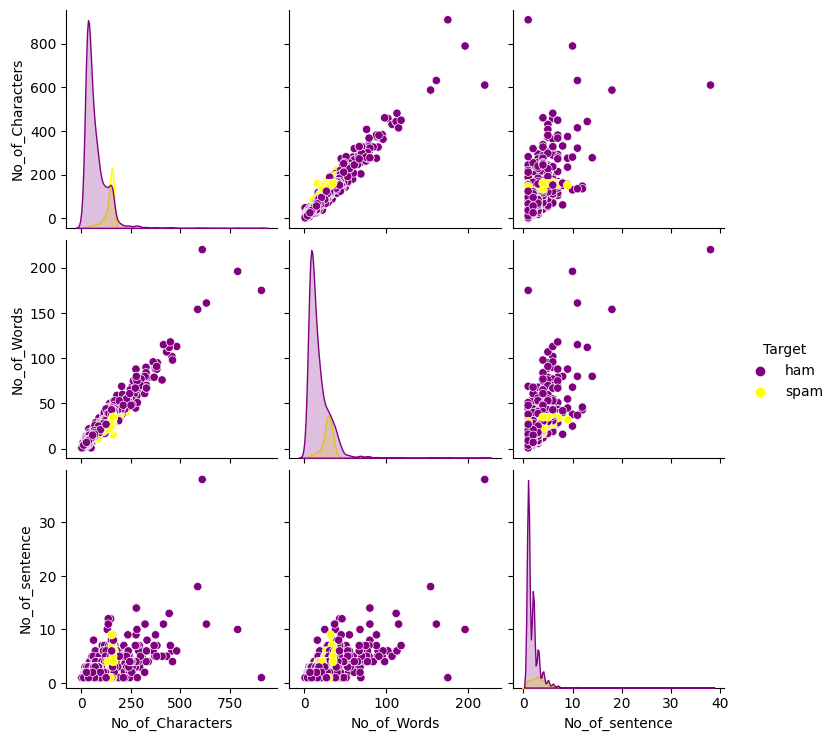

In [11]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=['purple','yellow'])
plt.show(fg)

# **Outlier Detection**
---

In [12]:
#Dropping the outliers. 
data = data[(data["No_of_Characters"]<350)]
data.shape

(5548, 5)

<Figure size 1200x800 with 0 Axes>

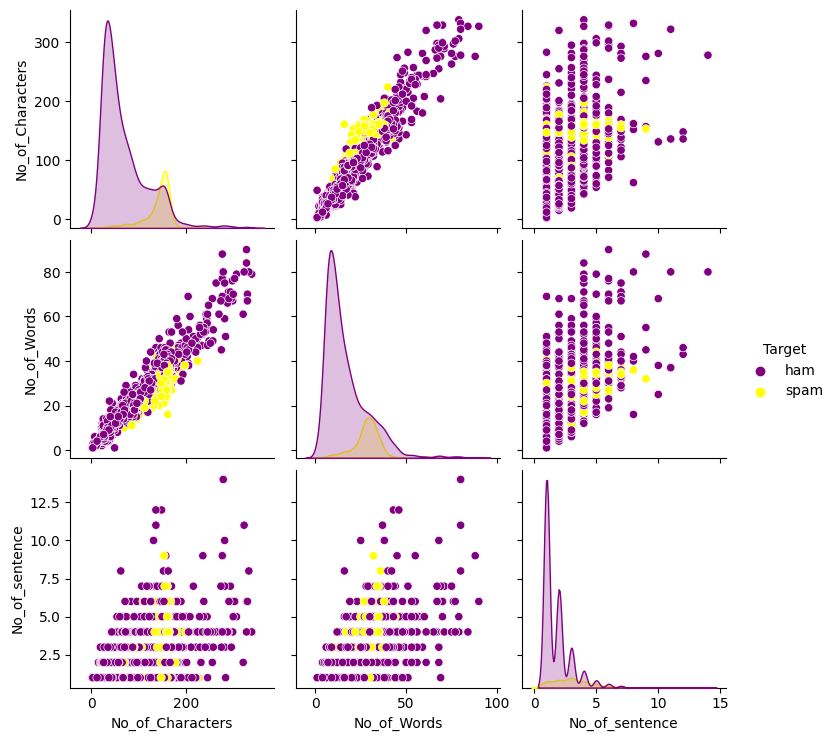

In [13]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=['purple','yellow'])
plt.show(fg)

# **Data Pre-Processing**
---

## **Data Cleaning**
---

In [14]:
data.head()

,Target,Text,No_of_Characters,No_of_Words,No_of_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [15]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data.loc[:, "Clean_Text"] = data["Text"].apply(Clean)

In [16]:
data

,Target,Text,No_of_Characters,No_of_Words,No_of_sentence,Clean_Text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,35,4,this is the nd time we have tried contact u u ...
5568,ham,Will Ì_ b going to esplanade fr home?,37,9,1,will b going to esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",57,15,2,pity was in mood for that so any other suggest...
5570,ham,The guy did some bitching but I acted like i'd...,125,27,1,the guy did some bitching but i acted like i d...


## **Tokenization**
---

In [17]:
data.loc[:, "Tokenize_Text"] = data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

In [18]:
data.head()

,Target,Text,No_of_Characters,No_of_Words,No_of_sentence,Clean_Text,Tokenize_Text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,..."


## **Removing Stop Words**
---

In [19]:
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data.loc[:, "Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

In [20]:
data[['Tokenize_Text','Nostopword_Text']].head()

,Tokenize_Text,Nostopword_Text
0,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]"


## **Stemming & Lemmatization**
---
Stemming is the process of getting the root form of a word. Stem or root is the part to which inflectional affixes are added. The stem of a word is created by removing the prefix or suffix of a word. It goes back to the etymology of the word. Languages evolve over time. Many different languages branch into each other; for example, English is a derivative of Latin. Thus, stemming a word takes it back to the root word.

lemmatization also converts a word to its root form. However, the difference is that lemmatization ensures that the root word belongs to the language one is dealing with, in our case it is English. If we use lemmatization the output would be in English.

In [21]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = [stemmer.stem(word) for word in text]
    return text

In [22]:
data.loc[:, 'Stemmed_Text'] = data['Nostopword_Text'].apply(stemm_text).copy()
data.head()

,Target,Text,No_of_Characters,No_of_Words,No_of_sentence,Clean_Text,Tokenize_Text,Nostopword_Text,Stemmed_Text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entri, wkli, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, goe, usf, live, around, though]"


In [23]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word) for word in text]
    return lemmas

# data.loc[:, "Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)

# **Vectorization**
---
TF-IDF in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.

Term Frequency (TF) = (Frequency of a term in the document)/(Total number of terms in documents) Inverse Document Frequency(IDF) = log( (total number of documents)/(number of documents with term t)) I will be using TfidfVectorizer() to vectorize the preprocessed data.

Steps in the Vectorizing:

Creating a corpus of lemmatized text
Converting the corpus in vector form
Label Encoding the classes in Target

In [24]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in data["Stemmed_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]

['go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'ok lar joke wif u oni',
 'free entri wkli comp win fa cup final tkts st may text fa receiv entri question std txt rate c appli',
 'u dun say earli hor u c alreadi say',
 'nah think goe usf live around though']

In [25]:
#Changing text data in to numbers. 
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature 
X.dtype

dtype('float64')

In [26]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
data.loc[:, "Target"] = label_encoder.fit_transform(data["Target"])

In [27]:
data.head()

,Target,Text,No_of_Characters,No_of_Words,No_of_sentence,Clean_Text,Tokenize_Text,Nostopword_Text,Stemmed_Text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entri, wkli, comp, win, fa, cup, final,..."
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, goe, usf, live, around, though]"


# **Build the Model**
---
Steps involved in the Model Building

* Setting up features and target as X and y
* Splitting the testing and training sets
* Build a pipeline of model for four different classifiers.
    * Naïve Bayes
    * RandomForestClassifier
    * KNeighborsClassifier
    * Support Vector Machines
* Fit all the models on training data
* Get the cross-validation on the training set for all the models for accuracy

In [28]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = data["Target"].astype(int)
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
#Testing on the following classifiers
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               KNeighborsClassifier(), 
               SVC()]

for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [30]:
# Cossvalidation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.968227 
RandomForest: 0.974987 
KNeighbours: 0.912127 
SVC: 0.974538 


# **Model Evaluation**
---

In [31]:
# Model Evaluation
# creating lists of varios scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [32]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [33]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1.000000,0.705882,0.827586,0.976577,0.997521
RandomForest,1.000000,0.830882,0.907631,0.976577,0.997521
KNeighbours,0.977778,0.323529,0.486188,0.976577,0.997521
SVC,0.991071,0.816176,0.895161,0.976577,0.997521


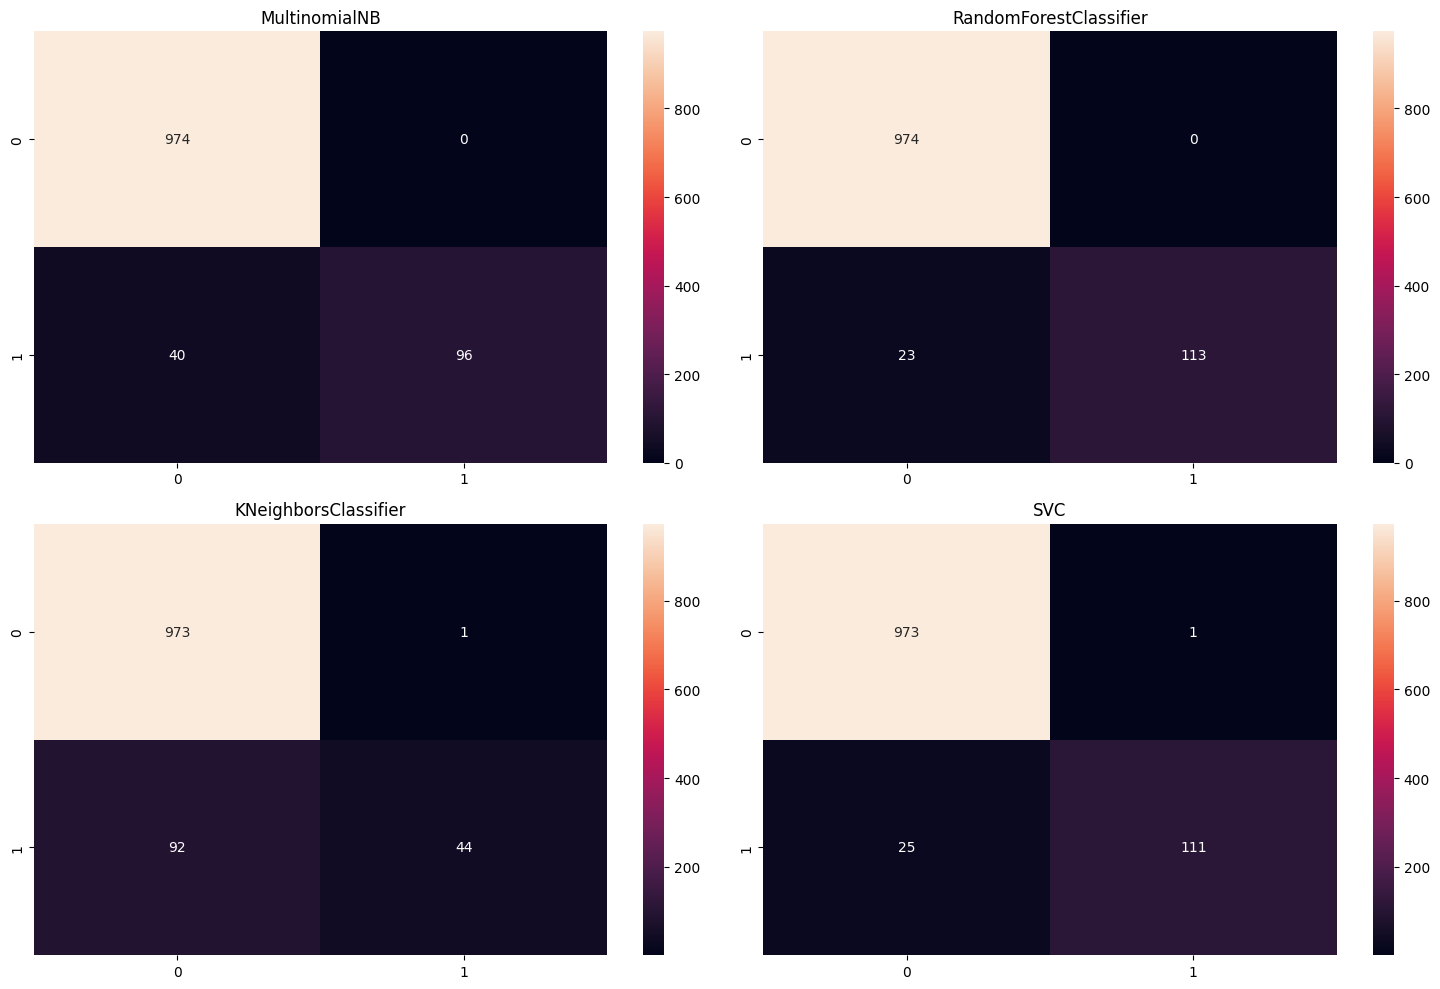

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for cls, ax in zip(classifiers, axes.flatten()):
    y_pred = cls.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax)
    ax.set_title(type(cls).__name__)

plt.tight_layout()
plt.show()

In [35]:
# Initialize a list to store the results
predictions_results = []

# Loop through each model
for i, model in enumerate(classifiers):
    # Predict labels for both training and testing sets
#     pred_train = model.predict(X_train)
#     pred_test = model.predict(X_test)
    
    # Check if the prediction is correct
    correct_train = (pred_train == y_train).tolist()
    correct_test = (pred_test == y_test).tolist()
    
    # Append the results to the list
    predictions_results.append({
        'Model': pipe_dict[i],
        'Train Predictions': pred_train,
        'Train Correct': correct_train,
        'Test Predictions': pred_test,
        'Test Correct': correct_test
    })

# Create a DataFrame from the results list
predictions_df = pd.DataFrame(predictions_results)

In [36]:
predictions_df

,Model,Train Predictions,Train Correct,Test Predictions,Test Correct
0,NaiveBayes,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[True, True, True, True, True, True, True, Tru...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[True, True, True, True, True, True, True, Tru..."
1,RandomForest,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[True, True, True, True, True, True, True, Tru...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[True, True, True, True, True, True, True, Tru..."
2,KNeighbours,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[True, True, True, True, True, True, True, Tru...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[True, True, True, True, True, True, True, Tru..."
3,SVC,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[True, True, True, True, True, True, True, Tru...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[True, True, True, True, True, True, True, Tru..."


In [37]:
# Filter the DataFrame for Naive Bayes model
naive_bayes_results = predictions_df[predictions_df['Model'] == 'NaiveBayes'].iloc[0]

# Create a new DataFrame for Naive Bayes results
naive_bayes_df = pd.DataFrame({
    'Actual Test': y_test.tolist(),
    'Test Predictions': naive_bayes_results['Test Predictions'],
    'Test Result': naive_bayes_results['Test Correct']
})

# Display the Naive Bayes DataFrame
print(naive_bayes_df)

      Actual Test  Test Predictions  Test Result
0               0                 0         True
1               0                 0         True
2               0                 0         True
3               0                 0         True
4               0                 0         True
...           ...               ...          ...
1105            0                 0         True
1106            0                 0         True
1107            1                 1         True
1108            0                 0         True
1109            0                 0         True

[1110 rows x 3 columns]


In [38]:
incorrect_predictions_df = naive_bayes_df[naive_bayes_df['Test Result'] == False]

incorrect_predictions_df

,Actual Test,Test Predictions,Test Result
171,1,0,False
205,1,0,False
240,1,0,False
307,1,0,False
324,1,0,False
326,1,0,False
373,1,0,False
394,1,0,False
432,1,0,False
578,1,0,False


# **References**
---
* https://www.kaggle.com/code/karnikakapoor/spam-or-ham-sms-classifier
* https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained
* https://www.kaggle.com/code/faressayah/natural-language-processing-nlp-for-beginners